## Coin Segmentation

Using watershed and region properties. What th aim of this notebook is to isolate the coins from the darker background image. 

In [1]:
import skimage
skimage.__version__

'0.14.2'

In [18]:

from skimage import data
from skimage import filters
from skimage import feature
from skimage import measure
from skimage import morphology, segmentation
from skimage import color

import numpy as np
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

In [3]:
# Load dataset
coins = data.coins()

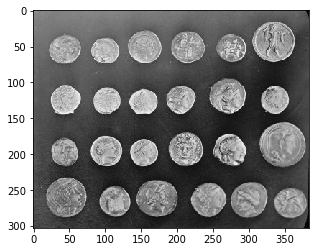

In [4]:
plt.imshow(coins, cmap='gray');

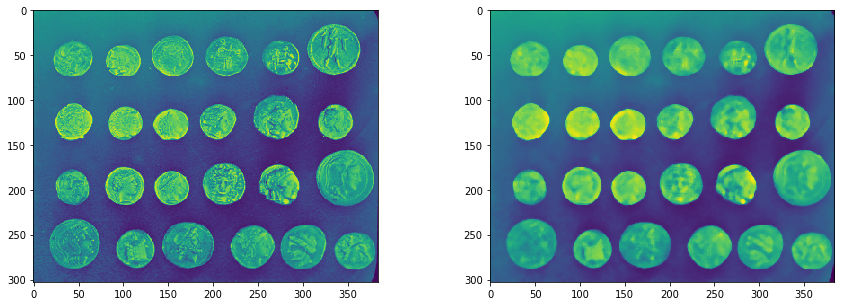

In [5]:
# Smooth out the image a bit (i.e. denoise it) by applying a median filtering
coins_denoised = filters.median(coins, selem=np.ones((5,5)))

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,5))

# First image provides a lot details in the image
ax0.imshow(coins);

# After applying the structuring element (selem) gets rid of most of the noise for us
ax1.imshow(coins_denoised);

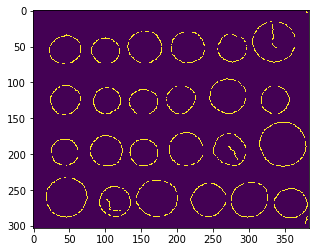

In [6]:
# Next step is to find the edges of the coins by employing the canny edge detector 
edges = skimage.feature.canny(coins, sigma=3) # sigma adjusts the width of the canny, that is how sensitive it is to edges
# Note: setting sigma to 1 will result it very noisy edge detection results, while a value of 5 results in gaps in edge detection image.

plt.imshow(edges);

### Watershed algorithm

Use a watershed algorithm, which images the image as a landscape, and we fill the landscape with water.

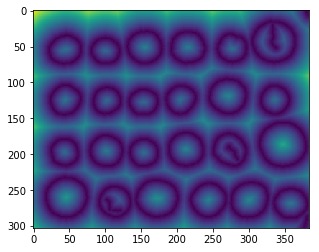

In [7]:
# Convert image into a landscape for that we use distance transformation.
dt = distance_transform_edt(~edges) # edt stands for Euclidean distance transform

plt.imshow(dt);

We call the Euclidean distance trans on the negative of the edges, since the distance transform defines as the distances closest to the background pixel as applied to the edges seen in the previous cell above. We apply it to the inverse of the edge mask to make the foreground the background and the background the foreground, we get a much more interesting result. 

This method tells us how far are we away from a coin edge. As we can see above that in the middle of the coin we are fairly far away and outside of the coin we are also fairly far away, but on the edge of the coin itself we are very close to the edge of that coin. 

This is the landscape we will now fill up using the watershed algorithm. In order to do that we need to find the locations of those fountains and we do this by using the peak local max function, to find local peaks in this landscape. 

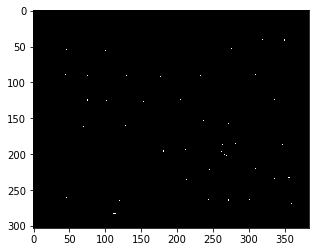

In [8]:
local_max = feature.peak_local_max(dt,
                                  indices=False,
                                  min_distance=5)

plt.imshow(local_max, cmap='gray');

The white dots seen above are the locations of the fountains, we can visualize peaks detedcted, used in the watershed method.

In [9]:
peak_idx = feature.peak_local_max(dt,
                                  indices=True, # set to true to return positions of peaks detected
                                  min_distance=5)
peak_idx[:5] # print the first five peaks detected

array([[283, 116],
       [283, 115],
       [283, 114],
       [283, 113],
       [282, 115]])

We can now better visualize the peaks by looking at the actual positions with the plot above 

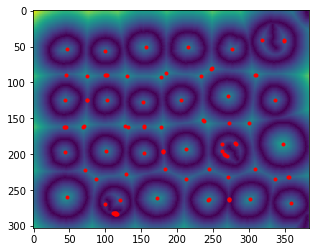

In [10]:
# Visualize all the peaks we have found
plt.plot(peak_idx[:, 1], peak_idx[:,0], 'r.')
plt.imshow(dt);

These will be positions of the fountains that we will use to flood this landscape. 

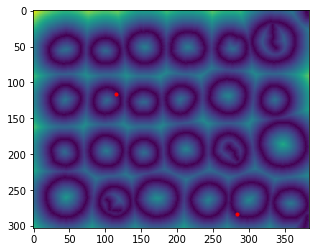

In [11]:
# Visualize a pair of peaks
plt.plot(peak_idx[1], peak_idx[0], 'r.')
plt.imshow(dt);

Next we will be labeling each of these features. We are going to give them each individual numbers, starting from zero and counting upwards. This number is used by the watershed algorithm to label the region that forms around the fountain.  

In [12]:
markers = measure.label(local_max) # Each new point gets an integer label. 

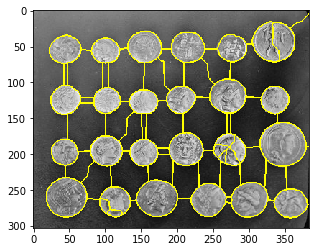

In [13]:
# Execute the watershed algorithm on our distance map with the given labeled markers
labels = morphology.watershed(-dt, markers)
plt.imshow(segmentation.mark_boundaries(coins, labels));

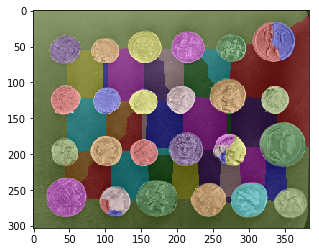

In [14]:
plt.imshow(color.label2rgb(labels, image=coins));

This gives us a slightly different visualization of the labeling throgh segmentation with RGB coloring. The background here is definitely well separated from the different coins. Some of the coins got split in half (coins having multiple colors) as seen above. Now the question becomes how can we merge the appropriate regions together. 

Let's do another visualization of the segmentation calling the label RGB again, but instead of using colors to represent areas to average the pixel values underlying those areas and we can display those below.

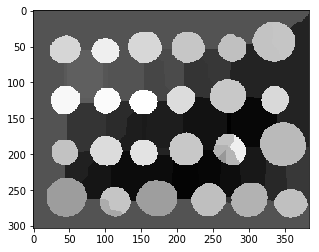

In [15]:
plt.imshow(color.label2rgb(labels, image=coins, kind='avg'), cmap='gray');

So when we do that we see that the coins as we have observed before are ligher than the background in general, thus we should be able to split the foreground and the background just looking at their intensities.

First let's look at all the different regions identified here so that we are goign to be using region props, which will calculate fore each object that you see in here so that object will have a region property, a set of region properties calculated for each coin we shere here and for the coints that have been segmented into multiple parts will have a region a set of region properties for each.

In [16]:
# List of region properties stored 
regions = measure.regionprops(labels, intensity_image=coins)

In [22]:
measure.regionprops?

Signature:
measure.regionprops(
    ['label_image', 'intensity_image=None', 'cache=True', 'coordinates=None'],
)
Docstring:
Measure properties of labeled image regions.

Parameters
----------
label_image : (N, M) ndarray
    Labeled input image. Labels with value 0 are ignored.

    .. versionchanged:: 0.14.2
        Previously, ``label_image`` was processed by ``numpy.squeeze`` and
        so any number of singleton dimensions was allowed. This resulted in
        inconsistent handling of images with singleton dimensions. To
        recover the old behaviour, use
        ``regionprops(np.squeeze(label_image), ...)``.
intensity_image : (N, M) ndarray, optional
    Intensity (i.e., input) image with same size as labeled image.
    Default is None.
cache : bool, optional
    Determine whether to cache calculated properties. The computation is
    much faster for cached properties, whereas the memory consumption
    increases.
coordinates : 'rc' or 'xy', optional
    Coordinate convention

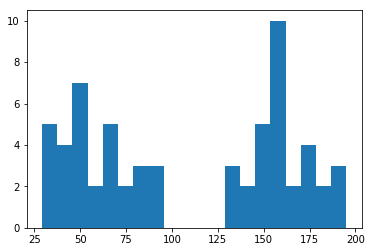

In [17]:
# Now compute the mean intensity for each of these regions
region_means = [r.mean_intensity for r in regions]

# Draw histogram
plt.hist(region_means, bins=20);

We can see that here is a very clear separation, between the mean intensity of objects associated with the background (left histogram clsuter) and mean intensities of objects associated with coins (right histogram clusters). We can split them at around 110 line we should have a pretty good segmentation. This is how it is accomplished by hand manually. But we can automate this by instead using the K-means cluster algorithm, by doing a cluster of the background and the foreground intensities, to handle the decision between foreground and background. 

In [20]:
# Format data by reshaping into column-wise numpy array
region_means = np.array(region_means).reshape(-1, 1)

# We tell K-means we are interested in learning about 2 clusters by providing the region means
model = KMeans(n_clusters=2)

# Train K-means clustering model (fitted to the means)
model.fit(region_means)

# Display the centroids of the two clusters.
print(model.cluster_centers_)

[[160.09302022]
 [ 57.68675417]]


We see K-means algorithm found two clusters centered around 160 and the other clustered centered around 57. 

In [21]:
# Ask model to predict labels for each of the region centers providing the labels as either foreground or background
bg_fg_labels = model.predict(region_means)
print(bg_fg_labels)

[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0]


In [ ]:
All that remains is to label the image appropriately.

In [23]:
classified_labels = labels.copy() # copy original labels

In [24]:
# Take combination of predicted labels with the different regions and then re-label the image according to the coordinates of each region.
# and assign that to whether it's background or foreground (i.e. coin)
for bg_fg, region in zip(bg_fg_labels, regions):
    classified_labels[tuple(region.coords.T)] = bg_fg

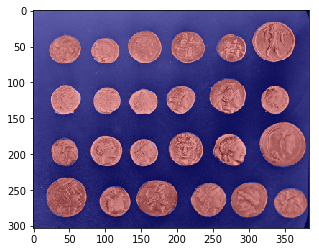

In [25]:
plt.imshow(color.label2rgb(classified_labels, image=coins));

### Conclusion

We were able to classify labels for the foreground perfectly isolated from the background.